For this analysis, a set of data was used, detailing the gifts to public officials registered with the Anti-Corruption Office.
<a href="https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos" target="_blank">Source</a><br/><br/>
**Ranges from 10/02/2017 to 08/10/2020.**

In Argentina, Law 25,188 on Ethics in the Exercise of Public Service prohibits civil servants from receiving gifts or donations on the occasion of or in connection with the performance of their duties. <br/><br/>

As an exception, they may receive those gifts that are given for reasons of courtesy or diplomatic custom, but only under the circumstances established in the aforementioned law and in Decree 1179/16 (Regime of Gifts to Public Officials).<br/><br/>

For their part, all gifts - admitted by law 25,188 - must be registered and - when they exceed a certain value (more than 4 modules) or have institutional significance - must be incorporated into the State's assets. <br/><br/>

According to the <a target="_blank" href="https://desafiospublicos.argentina.gob.ar/normativa/nacional/decreto-1030-2016-265506/texto">Decree 1030/2016</a>, the value of the module (M) will be of ARGENTINE PESOS ONE THOUSAND ($ 1,000).

In [59]:
#we import needed libreries
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
import os
import numpy as np
import fuzzywuzzy
import string
import requests

from fuzzywuzzy import process
from os import path
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

In [60]:
# we save the location in order to save later the images we generate
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print(f'Loaded records: {len(data)}')

Loaded records: 3928


In [61]:
# limpieza y unificación de features
data["funcionario_nombre"] = data["funcionario_nombre_completo"].apply(str.title) + " " + data["funcionario_apellido_completo"].apply(str.title)
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [62]:
def replace_matches_in_column(df, column, string_to_match, min_ratio=90):
    strings = df[column].unique()
    
    # obtener el top 10 de similitudes más cercanas al string que estamos analizando
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # filtramos y nos quedamos sólo con las coincidencias con un ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    rows_with_matches = df[column].isin(close_matches)
    df.loc[rows_with_matches, column] = string_to_match

When looking at the names of officials, we can notice that there are "repeats", either by different amount of spaces between words, by use (or not) of accents and other reasons. <br/>
To verify this (and to fix it) we will use <a href="https://github.com/seatgeek/fuzzywuzzy" target="_blank">fuzzywuzzy</a>. <br/><br/>
In the next cell we will see how many names like "Matías Daniel Lammens Núñez".<br/>

The number next to the name variant is the percentage of similarity (you can choose different methods to analyse how similar they are, in this case we choose 'token_sort_ratio').


In [63]:
df = data["funcionario_nombre"].unique()
df.sort()

matches = fuzzywuzzy.process.extract("Matías Daniel Lammens Núñez", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
print(matches)

[('Matías Daniel Lammens Núñez', 100), ('Matias Daniel Lammens Núñez', 98), ('Matías Daniel Lammens Nuñez', 98), ('Matías Lammens', 70), ('Matias Lammens', 68), ('Diana Maria Guillen', 56), ('Daniel Meilan', 54), ('Ramón María Lanús', 53), ('Maria Gabriela Real', 51), ('Marta Gabriela Michetti', 51)]


In [64]:
print('Number of names of politicians')
print(f'Before cleaning: {len(df)}')

names_to_replace = [{"name": "Alberto Angel Fernandez", "min_ratio":80}, {"name": "Germán Carlos Garavano", "min_ratio":84}, {"name": "Matías Daniel Lammens Núñez", "min_ratio":67}, {"name":"Patricia Bullrich" , "min_ratio":75}]

for item in names_to_replace:
    replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match=item.get("name"), min_ratio=item.get("min_ratio"))

names_to_replace = ["Agustin Dellagiovanna", "Alberto Jorge Triaca", "Carlos Vicente Ruá", "Cristina E. Fernández O Néstor C. irchner", "Cristián Roberto Dellepiane Rawson", "Damián Eduardo Arabia", "Dante Sica", "Fernando Félix Grasso", "Gustavo José Santos", "José Lino Salvador Barañao", "Marcelo Gabriel Suárez Salvia", "Maria Inés Baque", "Marta Gabriela Michetti", "María Eugenia Bielsa", "María Lara González Carvajal", "Ramón Lanús", "Ramón María Lanús", "Ricardo Agustín Campero", "Roberto Salvarezza", "Rogelio Frigerio", "Santiago Tomás Bellomo", "Mauricio Macri"]

for name in names_to_replace:
    replace_matches_in_column(df=data, column='funcionario_nombre', string_to_match=name)

df = data["funcionario_nombre"].unique()
df.sort()
print(f'After cleaning: {len(df)}')

Number of names of politicians
Before cleaning: 366
After cleaning: 326


In [65]:
#considerando que también hay varios roles con nombres similares..  necesitamos unificarlos
data["funcionario_funcion"] = data["funcionario_funcion"].str.lower()
data["funcionario_funcion"] = data["funcionario_funcion"].str.strip()

def cleanTxt(text):
 text = text.replace("registro de obsequios- señor presidente de la nación",'señor presidente de la nación')
 text = text.replace("hija de la señora de macri", "hija de la señora primera dama, srita valentina barbier")
 text = text.replace("hija del presidente de la nación de la nación, srita. antonia macri", "hija del presidente de la nación, srita. antonia macri")
 text = text.replace("vicepreseidencia",'vicepresidente')
 text = text.replace("presiente",'presidente')
 return text

data["funcionario_funcion"] = data.funcionario_funcion.apply(cleanTxt)

In [66]:
# I borrowed this from José https://github.com/casanovajose/lo_regalito
def obsequiador_name(row):
  name = []
  data = []
  nombre = row["obsequiador_nombre_completo"]
  apellido = row["obsequiador_apellido_completo"]    
  razon_social = row["obsequiador_razon_social"]
  organismo = row["obsequiador_organismo"]
  descripcion = row["obsequiador_descripcion"]  
  if type(nombre) == str:
      name.append(nombre)
      
  if type(apellido) == str:
      name.append(apellido)
      
  name = " ".join(name)
  name = name.strip()  
  if type(razon_social) == str:
      data.append(razon_social)
      
  if type(organismo) == str:
      data.append(organismo)  
  if type(descripcion) == str:
      data.append(descripcion)  
  if len(name) > 0:
      data.insert(0, name)

  return " | ".join(data)

data["obsequiador_nombre"] = data.apply(obsequiador_name, axis=1)

In [67]:
# We check similar roles and determine the min_ratio we should use to replace what we want to replace
df = data["funcionario_funcion"].unique()
matches = fuzzywuzzy.process.extract("presidente", df, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
print(matches)

[('presidente', 100), ('presidente.', 100), ('vicepresidente', 83), ('presidente - aabe', 80), ('presidente aabe', 80), ('vicepresidenta', 75), ('presidente de nación', 69), ('presidente de la nación', 62), ('presidente de la  nación', 62), ('presidente de la naciòn', 62)]


In [68]:
df = data["funcionario_funcion"].unique()
df.sort()
print('Number of roles from politicians')
print(f'Before cleaning: {len(df)}')

roles_to_replace = [{"role": "ministra de relaciones exteriores y culto", "min_ratio": 85}, {"role": "ministro de producción y trabajo", "min_ratio": 80}, {"role": "secretario general de la presidencia de la nación", "min_ratio": 80}, {"role": "señora primera dama", "min_ratio": 65}, {"role": "subsecretario", "min_ratio": 88}, {"role": "titular", "min_ratio": 70}, {"role": "ministra de seguridad", "min_ratio":78}, {"role": "ministro de educación y deportes de la nación", "min_ratio": 84}, {"role": "hija de la señora primera dama, srita valentina barbier", "min_ratio": 62}, {"role": "ministro de educación, cultura, ciencia y tecnología", "min_ratio": 85}, {"role": "ministro de agricultura, ganadería y pesca de la nación", "min_ratio": 85}, {"role": "secretario de coordinación de políticas públicas", "min_ratio": 79}, {"role": "jefa del dpto de priv, e inmun, acred. y guía diplo", "min_ratio": 82}, {"role": "presidencia de la nación", "min_ratio": 87}, {"role": "hija del presidente de la nación, srita. antonia macri", "min_ratio": 75}, {"role": "secretario de relaciones exteriores", "min_ratio": 97}, {"role": "presidente", "min_ratio": 100}]

for item in roles_to_replace:
    replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match=item.get("role"), min_ratio=item.get("min_ratio"))

roles_to_replace = ["jefe de gabinete de ministros", "directora nacional de ética pública", "ministro de turismo y deportes", "ministro de turismo", "secretaría de ética pública transparencia y lucha contra la corrupción", "secretaria de relaciones políticas y parlamentarias", "secretario de economía social", "secretario de gobierno de energia", "secretario de seguridad interior", "subsecretario de política exterior", "coordinador de relaciones institucionales con dependencia directa del ministerio de produccion", "coordinador/a general", "ministra de seguridad de la nación", "jefa de gabinete", "presidente - aabe", "secretario de agricultura, ganadería y pesca", "supervisor de fiscalización", "vicepresidente de la nación"]

for role in roles_to_replace:
    replace_matches_in_column(df=data, column='funcionario_funcion', string_to_match=role)

df = data["funcionario_funcion"].unique()
df.sort()
print(f'After cleaning: {len(df)}')

Number of roles from politicians
Before cleaning: 294


After cleaning: 214


In order to make comparisons between the amount of gifts received more objective we will calculate: <br/>`amount of gifts / amount of days in office` <br/><br/>
Since we only do this for the first 10 politicians, we "manually" calculate the days in charge (by calculating the overlap between the period in charge and the date range of the data we use).

In [69]:
#Date range of data used: 10/02/2017 to 08/10/2020
dias_en_cargo_mm = 1033 #Mauricio Macri
dias_en_cargo_af = 303 #Alberto Angel Fernandez    
dias_en_cargo_gg = 1033 #Germán Carlos Garavano     
dias_en_cargo_jf = 911 #Jorge Faurie               
dias_en_cargo_rf = 1033 #Rogelio Frigerio           
dias_en_cargo_sm = 122 #Susana Malcorra
dias_en_cargo_ja = 1033 #Juliana Awada
dias_en_cargo_mp = 1033 #Marcos Peña                
dias_en_cargo_at = 662 #Alberto Jorge Triaca - denuncia
dias_en_cargo_ml = 303 #Matías Daniel Lammens Núñez

dias_en_cargo = pd.Series([dias_en_cargo_mm, dias_en_cargo_af, dias_en_cargo_gg, dias_en_cargo_jf, dias_en_cargo_rf, dias_en_cargo_sm, dias_en_cargo_ja, dias_en_cargo_mp, dias_en_cargo_at, dias_en_cargo_ml])

/tmp/ipykernel_34784/2811176633.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


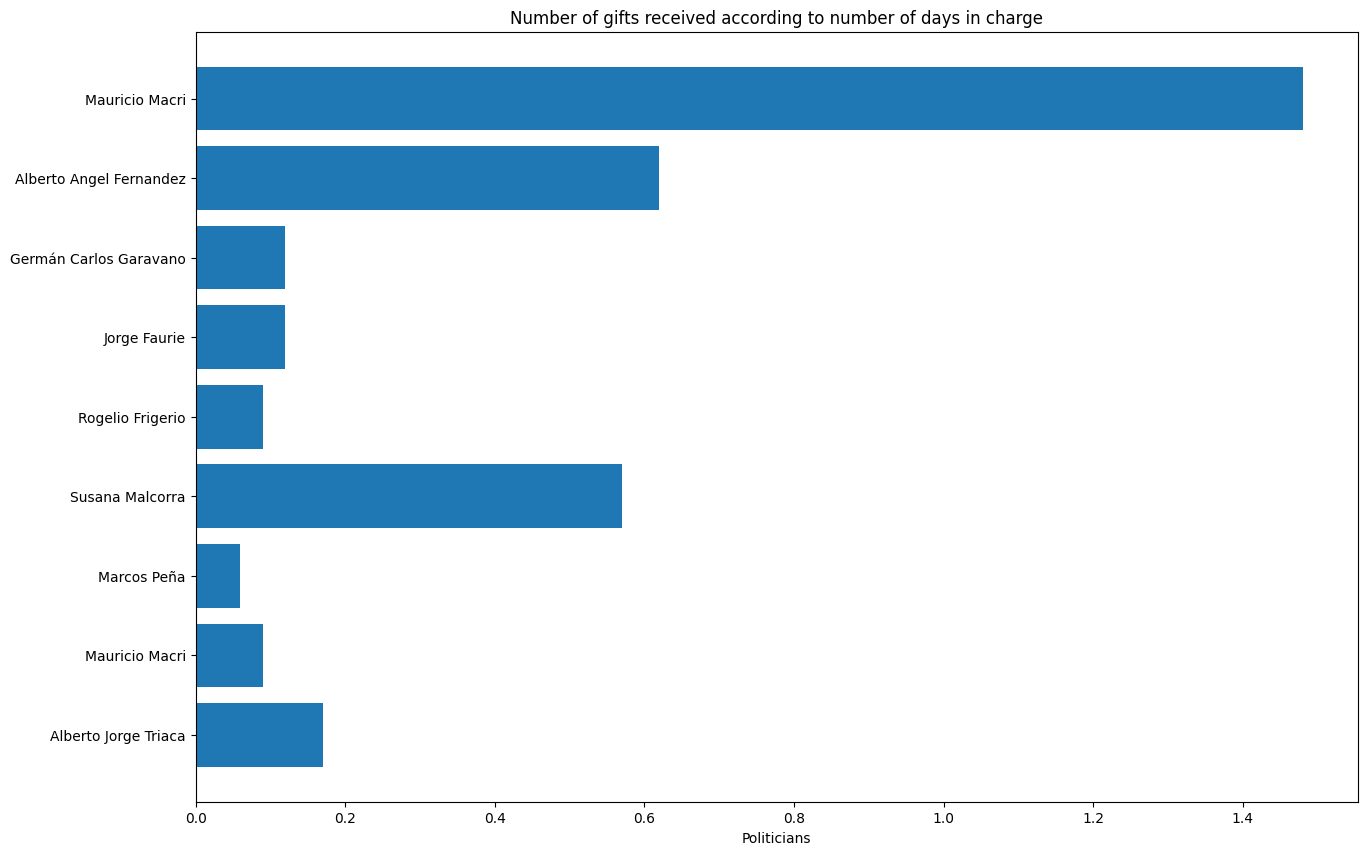

In [70]:
# As we initially converted the roles to lowercase to "clean and unify" them... now we convert them back to CamelCase
CANT_FUNCIONARIXS = 10
data["funcionario_funcion"] = data["funcionario_funcion"].str.title()

top_regalos = data
top_regalos['cantidad_de_regalos'] = 1
top_regalos = data.groupby(['funcionario_nombre', 'funcionario_funcion'], as_index=False).sum().sort_values('cantidad_de_regalos', ascending=False).reset_index().head(CANT_FUNCIONARIXS)
top_regalos = top_regalos[["funcionario_nombre", "cantidad_de_regalos"]]
top_regalos["cantidad_de_regalos"] = top_regalos["cantidad_de_regalos"].div(dias_en_cargo).round(2)


labels = list(top_regalos.funcionario_nombre)
values = list(top_regalos.cantidad_de_regalos)
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(labels, values, align="center")
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("Politicians")
ax.set_title("Number of gifts received according to number of days in charge")
plt.show()

We can see that Mauricio Macri received 1.4 gifts per day in his position, while the rest of the functionaries received much less.

Looking at these numbers, we were intrigued as to who were the people who held ministerial positions without indicating the area in which they worked and who received so many gifts that they were in the top 10.

According to Wikipedia:
* **Germán Garavano** served as Minister of Justice and Human Rights of the Argentine Republic from December 10, 2015 to December 9, 2019.<br/><img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/f/f2/German-garavano.jpg"/>

* **Rogelio Frigerio** was Minister of Home Affairs, Public Works and Housing in the government of Mauritius Macri from 10 December 2015 to 10 December 2019.<br/><img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/e/e7/Rogelio_Frigerio_2015.jpg"/>

* **Alberto Jorge Triaca** was appointed Minister of Labour in 2015 by Mauricio Macri, a position he held until 2018 when he was demoted to Secretary of Labour in the Ministry of Production following a cabinet reshuffle.<br/><img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/d/d6/Jorge_Triaca_hijo_%28cropped%29.jpg"/>

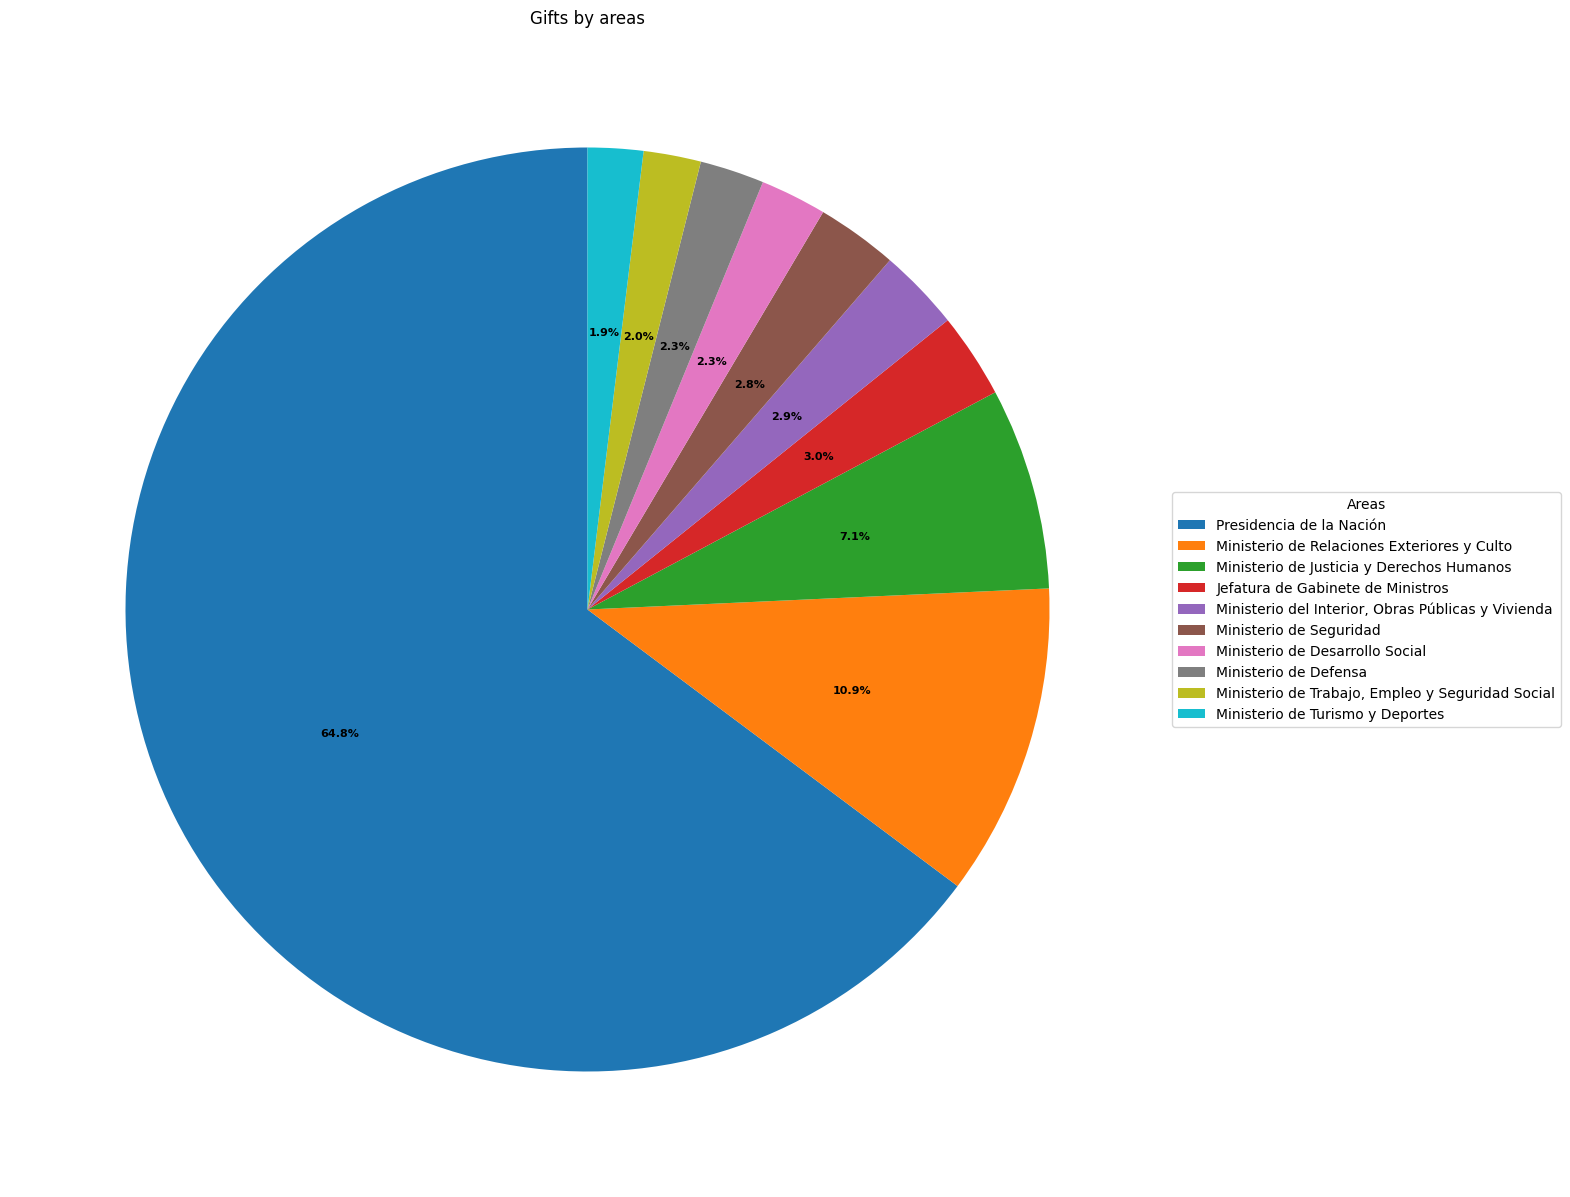

In [71]:
gifts_received_by_minister = data["funcionario_jurisdiccion"].value_counts().head(10)
labels = gifts_received_by_minister.keys()
values = gifts_received_by_minister.values

fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels, title="Areas", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Gifts by areas")
plt.show()

In [72]:
def make_wordcloud(data, filename=None):
    wc = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(data)
    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    if filename:
        wc.to_file(path.join(d, filename+".png"))

The 20 politicians who received the most gifts


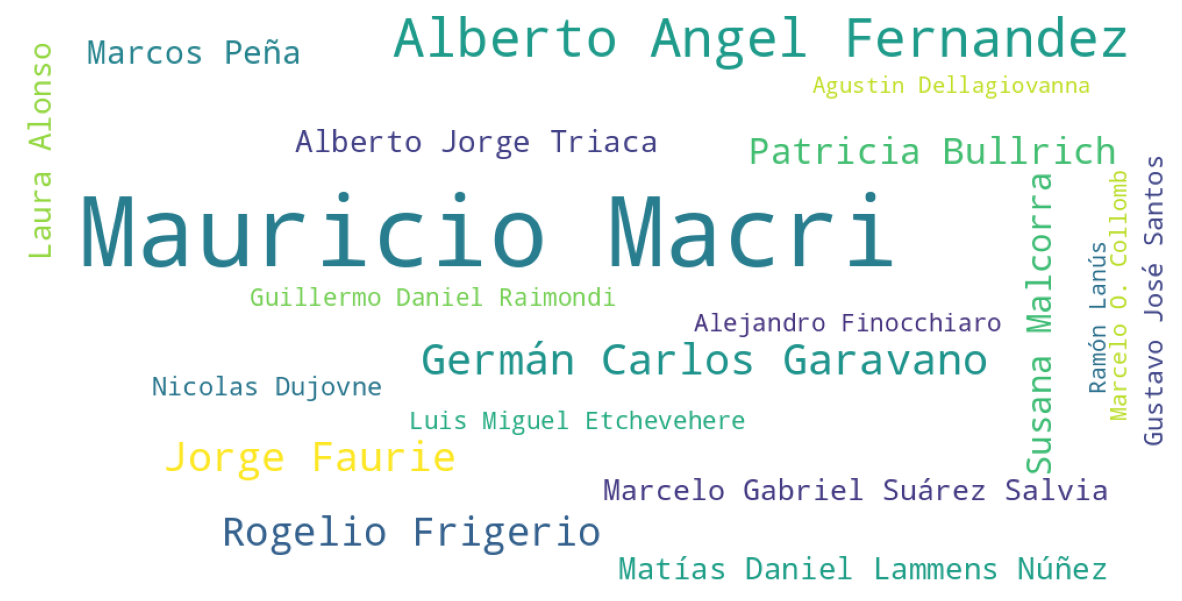

In [73]:
print("The 20 politicians who received the most gifts")
gift_by_func_counter = Counter(data.funcionario_nombre)
make_wordcloud(dict(gift_by_func_counter.most_common(20)))
#use it to save wordcloud as a file
#make_wordcloud(dict(gift_by_func_counter.most_common(20)), "roles_more_received_gifts_wordcloud") 

<img width="500px" src="https://info135.com.ar/wp-content/uploads/2017/07/macri-festeja.jpg"/>

## (Anti) Conclusions

In [74]:
def show_image_from_url(url, size=600):
    response = requests.get(url, stream=True)
    image = Image.open(response.raw)
    my_dpi = 100
    fig = plt.figure(figsize=(size/my_dpi, size/my_dpi), dpi=my_dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(image)
    plt.show()

Who gave gifts to Mauricio Macri and Alberto Fernandez?


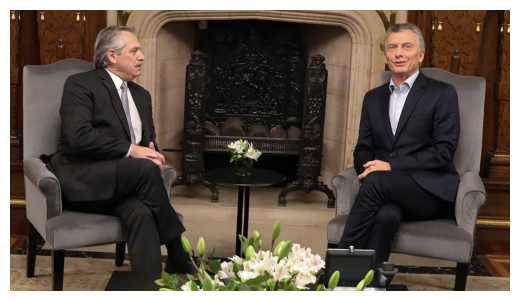

['Alejandro Dominguez',
 'Jorge Oscar Gornatti',
 'Mario Abdo',
 'Moon Jae-in',
 'Norberto Rodriguez',
 'Norelia Dabart',
 'Pedro Andrés Sulich',
 'Sindicato "La Fraternidad"']

In [75]:
print("Who gave gifts to Mauricio Macri and Alberto Fernandez?")
gifts_to_mmacri = data.loc[data["funcionario_nombre"] == "Mauricio Macri", "obsequiador_nombre"].unique()
gifts_to_afernandez = data.loc[data["funcionario_nombre"] == "Alberto Angel Fernandez", "obsequiador_nombre"].unique()
gifts_to_presidents = np.intersect1d(gifts_to_mmacri, gifts_to_afernandez)
gifts_to_presidents = gifts_to_presidents[np.where((gifts_to_presidents != "Ciudadana Ciudadana") & (gifts_to_presidents != "Ciudadano Ciudadano"))]

url = 'http://www.telam.com.ar/advf/imagenes/2019/10/5db759f9b690a_1004x565.jpg'
show_image_from_url(url, 500)

list(gifts_to_presidents)

In [76]:
print("Gifts made by people who gave both Mauricio Macri and Alberto Fernandez")
print("")

for obsequiador in gifts_to_presidents:
    print(f"Gifts made by {obsequiador}")
    gifts_from_x = data.loc[data["obsequiador_nombre"] == obsequiador, ["funcionario_nombre", "obsequio_descripcion"]]
    df = pd.DataFrame(gifts_from_x.values.tolist(), columns=gifts_from_x.columns.tolist())
    display(df)
    print("")

Gifts made by people who gave both Mauricio Macri and Alberto Fernandez

Gifts made by Alejandro Dominguez


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,un (1) poncho celeste
1,Mauricio Macri,"dos (2) remeras de fútbol de ""club atlético ta..."
2,Mauricio Macri,un (1) trofeo + medalla de conmebol
3,Alberto Angel Fernandez,una (1) camiseta de la selección argentina
4,Alberto Angel Fernandez,una (1) réplica de la copa américa/una (1) rép...



Gifts made by Jorge Oscar Gornatti


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro ""un hombre, una historia, un gremio"""
1,Mauricio Macri,"una (1) revista: "" lugares turísticos de la ar..."
2,Mauricio Macri,dos (2) revistas de el trabajador maderero
3,Alberto Angel Fernandez,"una (1) revista: ""suplemento de turismo social..."



Gifts made by Mario Abdo


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"una (1) botella de ron ""fortin"""
1,Mauricio Macri,un (1) sombrero de mimbre
2,Alberto Angel Fernandez,una (1) camisa de lino blanca



Gifts made by Moon Jae-in


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,una (1) caja con cintas y adhesivos del palace...
1,Alberto Angel Fernandez,un (1) adorno de pie tradicional coreano



Gifts made by Norberto Rodriguez


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro: ""valores, pensamiento crítico y ..."
1,Alberto Angel Fernandez,"un (1) libro: ""valores, pensamiento crítico y ..."



Gifts made by Norelia Dabart


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro: ""trauma"""
1,Alberto Angel Fernandez,"dos (2) cds: ""plenitud""/ ""semillas de mi"""



Gifts made by Pedro Andrés Sulich


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,"un (1) libro: ""pedro, caminante de la fe"""
1,Alberto Angel Fernandez,"dos (2) libros: ""pedro, caminante de la fe"""



Gifts made by Sindicato "La Fraternidad"


,funcionario_nombre,obsequio_descripcion
0,Mauricio Macri,una (1) escultura conmemorativa por el 130º an...
1,Alberto Angel Fernandez,"una (1) gorra con el logo del sindicato ""la fr..."


But... who are these people who gave the last two presidents away?

According to Wikipedia or Google:
* **Alejandro Guillermo Domínguez Wilson-Smith** is a Paraguayan businessman and sports leader who was elected president of the South American Football Confederation in 2016, a position he currently holds after his re-election in 2018 for the period 2019-2022. He is also the president of the FIFA Finance Committee.

* **Jorge Oscar Gornatti** Vice-President of the Social Work of the Wood Industry Staff, General Secretary of the Union of Wood Industry Unions of the Argentine Republic (USIMRA).

* Mario Abdo is a Paraguayan politician and businessman, current president of Paraguay since August 15, 2018. A member of the Colorado Party, before becoming president he was a senator in the Paraguayan Congress, where he also served as president of the Senate from 2015 to 2016. 

* Moon Jae-in is a South Korean politician, the current leader of the Korean Democratic Party and president of South Korea since May 10, 2017, after his victory in the presidential elections of that year. Moon was leader of the opposition in the 19th National Assembly before becoming president in 2015.

* Norberto Rodriguez is Secretary General of the YMCA.

* **Norelia Dabart** is a singer originally from Cordoba.

* Pedro Andrés Sulich gave the book "Pedro, Caminante de la fe" to both presidents.

* La Fraternidad" Union is an Argentinean union that groups locomotive and train drivers.


Of the people mentioned above, the one who caught my attention is the President of South Korea, Moon Jae-in. <br/>
<img width="200px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Moon_Jae-in_%282017-10-01%29_cropped.jpg/220px-Moon_Jae-in_%282017-10-01%29_cropped.jpg"/><br/>
Googleing a little I found this <a href="https://www.infobae.com/politica/2020/07/03/alberto-fernandez-dialogo-con-su-par-de-corea-del-sur-uno-de-los-paises-que-genera-discusiones-en-el-mercosur/" target="_blank">note</a> in which it says: _ "... Argentina had already objected to moving forward with this agreement with South Korea as well as with Singapore because of the possible trade disadvantages this would imply for the regional block."_ <br/>

In addition, the health authorities of the national governments of Korea and Argentina have a cooperative relationship in the face of the pandemic and have projected plans for cooperation in the field of health.

Could it be that so many gifts have something to do with the desire to make the free trade agreement between Argentina and South Korea a reality?

Bolsonaro "loves" Mauricio Macri but not to Alberto Fernandez


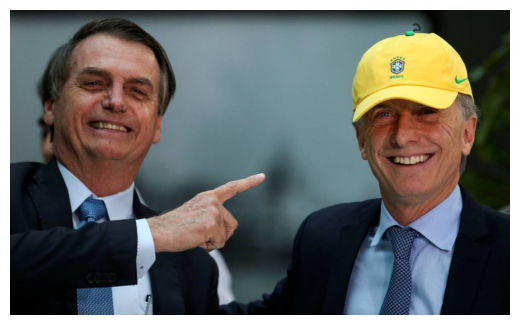

,funcionario_nombre,obsequio_descripcion
2762,Mauricio Macri,un (1) cuadro representativo de un cocard indi...
3138,Mauricio Macri,una (1) gorra de fútbol de brasil/un (1) vaso ...
3140,Mauricio Macri,una (1) pintura de flor
3361,Mauricio Macri,un (1) juego de vasijas de melamina


In [77]:
print('Bolsonaro "loves" Mauricio Macri but not to Alberto Fernandez')
gifts_from_bolsonaro = data.loc[data["obsequiador_nombre"] == "Jair Messias Bolsonaro", ["funcionario_nombre", "obsequio_descripcion"]]
show_image_from_url("https://ep01.epimg.net/internacional/imagenes/2019/06/10/argentina/1560202410_386123_1560202503_noticia_normal.jpg", 500)
gifts_from_bolsonaro

In [78]:
print("The gifts that were confiscated from Cristina Kirchner (Federal Criminal and Correctional Court Case 9608/18 11)")

confiscated_gifts = data.loc[data["obsequio_descripcion"].str.contains("causa 9608/18"), ["obsequiador_nombre", "obsequio_descripcion", "obsequio_valor_estimado"]]

def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de la comunicación", "")
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

# We clean gifts descriptions
confiscated_gifts["obsequio_descripcion"] = confiscated_gifts.obsequio_descripcion.apply(cleanTxt)

display(confiscated_gifts)

The gifts that were confiscated from Cristina Kirchner (Federal Criminal and Correctional Court Case 9608/18 11)


,obsequiador_nombre,obsequio_descripcion,obsequio_valor_estimado
2085,Se desconoce,lapicera cross de metal blanco,Superior a 4 módulos o imposibilidad de determ...
2086,Se desconoce,lapicera cartier color blanco,Superior a 4 módulos o imposibilidad de determ...
2087,Se desconoce,"lapicera y señalador con escudo nacional, ambo...",Superior a 4 módulos o imposibilidad de determ...
2088,Se desconoce,6 lapiceras montblanc y certif etoile de montb...,Superior a 4 módulos o imposibilidad de determ...
2089,Se desconoce,"rosa metálica,",Superior a 4 módulos o imposibilidad de determ...
2090,Se desconoce,escudo metálico de la provincia de entre ríos,Superior a 4 módulos o imposibilidad de determ...
2091,Sultán Saman Bin Al Abdullah,daga árabe en metal amarillo en su vaina con c...,Superior a 4 módulos o imposibilidad de determ...
2092,Luis Miguel .,"rosa metálica con una chapa que reza cristina,...",Superior a 4 módulos o imposibilidad de determ...
2093,Se desconoce,escultura metálica en forma de rosa,Superior a 4 módulos o imposibilidad de determ...
2094,Se desconoce,chapa metalica que reza sagai y rosa metálica,Superior a 4 módulos o imposibilidad de determ...


<img width="200px" src="https://aws.revistavanityfair.es/prod/designs/v1/assets/655x803/187136.jpg"/><br/>

Yeap you saw it well, Luis Miguel gave her a "metallic rose with a plate that reads: Cristina, with appreciation from Luis Miguel".<br/><br/>
We agree that since the gifts have a value greater than 4 modules or their value cannot be determined, they should have been incorporated into the State's assets.<br/><br/>
**And on top of that, the gifts have to be shared?
This is how the description of those who are the destination of the gifts appears (?)

In [79]:
data[data.funcionario_nombre.str.contains("Cristina E. Fernández")].funcionario_nombre.unique()[0]

'Cristina E. Fernández O Néstor C. irchner'

In [80]:
print("Who received food worth more than $4,000?")
alimentos = data.loc[(data.obsequio_tipo == "Alimentos") & (data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."), ["obsequiador_nombre", "funcionario_nombre", "funcionario_funcion", "obsequio_descripcion"]]
alimentos

Who received food worth more than $4,000?


,obsequiador_nombre,funcionario_nombre,funcionario_funcion,obsequio_descripcion
1284,Guillermo Calcagno,Ignacio Pérez Riba,Jefa De Gabinete,botellas de champagne don perignon (2)
1737,Ministro del Comercio Exterior y la Inversión ...,Marcos Peña,Jefe De Gabinete De Ministros,un (1) ron santiago de cuba extra añejo 25 año...
3676,"Ministerio de Agricultura, Ganadería y Abastec...",Luis Eugenio Basterra,"Ministro De Agricultura, Ganadería Y Pesca De ...","bebida cachaca, ""weber haus"", bebida alcohólic..."
3681,"Embajada de la India, Argentina Uruguay y Para...",Luis Eugenio Basterra,"Ministro De Agricultura, Ganadería Y Pesca De ...",2 latas de té de la india
3683,Administración General de la Aduana en China,Luis Eugenio Basterra,"Ministro De Agricultura, Ganadería Y Pesca De ...",4 cajas de té
3703,Embajada de la República Popular China en Arge...,Diana Maria Guillen,Titular De La Unidad Gabinete De Asesores,4 cajas de té


In [81]:
print("Who drank all the wine?")
vinos = data.loc[(data.obsequio_tipo == "Alimentos") & (data.obsequio_descripcion.str.contains("vino")), ["obsequiador_nombre", "funcionario_nombre", "funcionario_funcion", "obsequio_descripcion"]]

suma_vinos = vinos.copy()
suma_vinos['obsequios_que_incluyen_vinos'] = 1
suma_vinos = suma_vinos.groupby(["funcionario_nombre"]).sum().sort_values("obsequios_que_incluyen_vinos", ascending=False)
display(suma_vinos.head(10))

Who drank all the wine?


,obsequiador_nombre,funcionario_funcion,obsequio_descripcion,obsequios_que_incluyen_vinos
funcionario_nombre,,,,
Mauricio Macri,Audiencias con empresariosParticipante del Loc...,Presidencia De La NaciónPresidencia De La Naci...,una (1) botella de vino en un estuche con form...,30
Marcos Peña,Paola BíscaroMartín GrandeMartín GrandeRodolfo...,Jefe De Gabinete De MinistrosJefe De Gabinete ...,vino - encuentro cabernet sauvignon 2014 -le c...,18
Alberto Jorge Triaca,CONFEDERACION ARG. DE TRANSPORTE AUTOMOTOR DE ...,MinistroMinistroMinistroMinistroMinistroMinist...,caja de vinoscaja de vinosbotella de vinovino ...,17
Rogelio Frigerio,MINISTERIO DE HACIENDA Y FINANZAS DE SAN JUANJ...,MinistroMinistroMinistroMinistroMinistroMinist...,"2 cajas de vinovino espumante, whisky y alimen...",12
Santiago Bausili,GhellaSantander RíoGobierno de la Pcia. de Neu...,Secretario De FinanzasSecretario De FinanzasSe...,2 vinos luigi bosca malbec 20153 vinos cadus t...,10
Alejandro Finocchiaro,Universidad Abierta InteramericanaUniversidad ...,Ministro De Educación Y Deportes De La NaciónM...,vinovinos1 vinocaja con 2 vinoscaja de vinos1 ...,9
Marcelo Gabriel Suárez Salvia,Azulado S.A.Embajada de la República Argelina ...,Director Nacional De CeremonialDirector Nacion...,botella de vino malbec y botella vino espumoso...,7
Ramón Lanús,Munic. de NeuquénMunic. de TunuyánJosé Manuel ...,Presidente - AabePresidentePresidentePresident...,6 vinos sauruscaja de 6 vinos salenteinvino ru...,7
Matías García Oliver,Botella de Vino Escorihuela Gascón MalbecVino ...,SubsecretarioSubsecretarioSubsecretarioAsesorA...,botella de vino escorihuela gascón malbec-vino...,6


In [82]:
print("Who is most at risk of a liver attack?")
ataque_higado = data.copy()
cond_alimentos = data.obsequio_tipo == "Alimentos"
ataque_higado["wines"] = cond_alimentos & (data.obsequio_descripcion.str.contains("vino"))
ataque_higado["chocolates"] = cond_alimentos & (data.obsequio_descripcion.str.contains("chocolate"))
ataque_higado["salami"] = cond_alimentos & (data.obsequio_descripcion.str.contains("salam"))
ataque_higado["alfajores"] = cond_alimentos & (data.obsequio_descripcion.str.contains("alfajor"))

ataque_higado= ataque_higado[["funcionario_nombre", "wines", "chocolates", "salami", "alfajores"]]
ataque_higado.groupby(["funcionario_nombre"]).sum().sort_values(["wines", "chocolates", "salami", "alfajores"], ascending=False).head(10)

Who is most at risk of a liver attack?


,wines,chocolates,salami,alfajores
funcionario_nombre,,,,
Mauricio Macri,30,24,13,26
Marcos Peña,18,2,0,2
Alberto Jorge Triaca,17,0,0,0
Rogelio Frigerio,12,1,0,0
Santiago Bausili,10,0,0,0
Alejandro Finocchiaro,9,0,0,0
Ramón Lanús,7,0,0,1
Marcelo Gabriel Suárez Salvia,7,0,0,0
Ignacio Pérez Riba,6,0,0,0


In [83]:
# We created a function to clean gifts descriptions
def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'').replace("-",',').replace(" , ",', ')
 text = text.replace("\"",'')
 text = re.sub(r'\(([0-9]+)\)', '', text)
 text = re.sub(' +', ' ', text)
 text = text.strip()
 return text

expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]
expensive_gifts.loc[:,"obsequio_descripcion"] = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

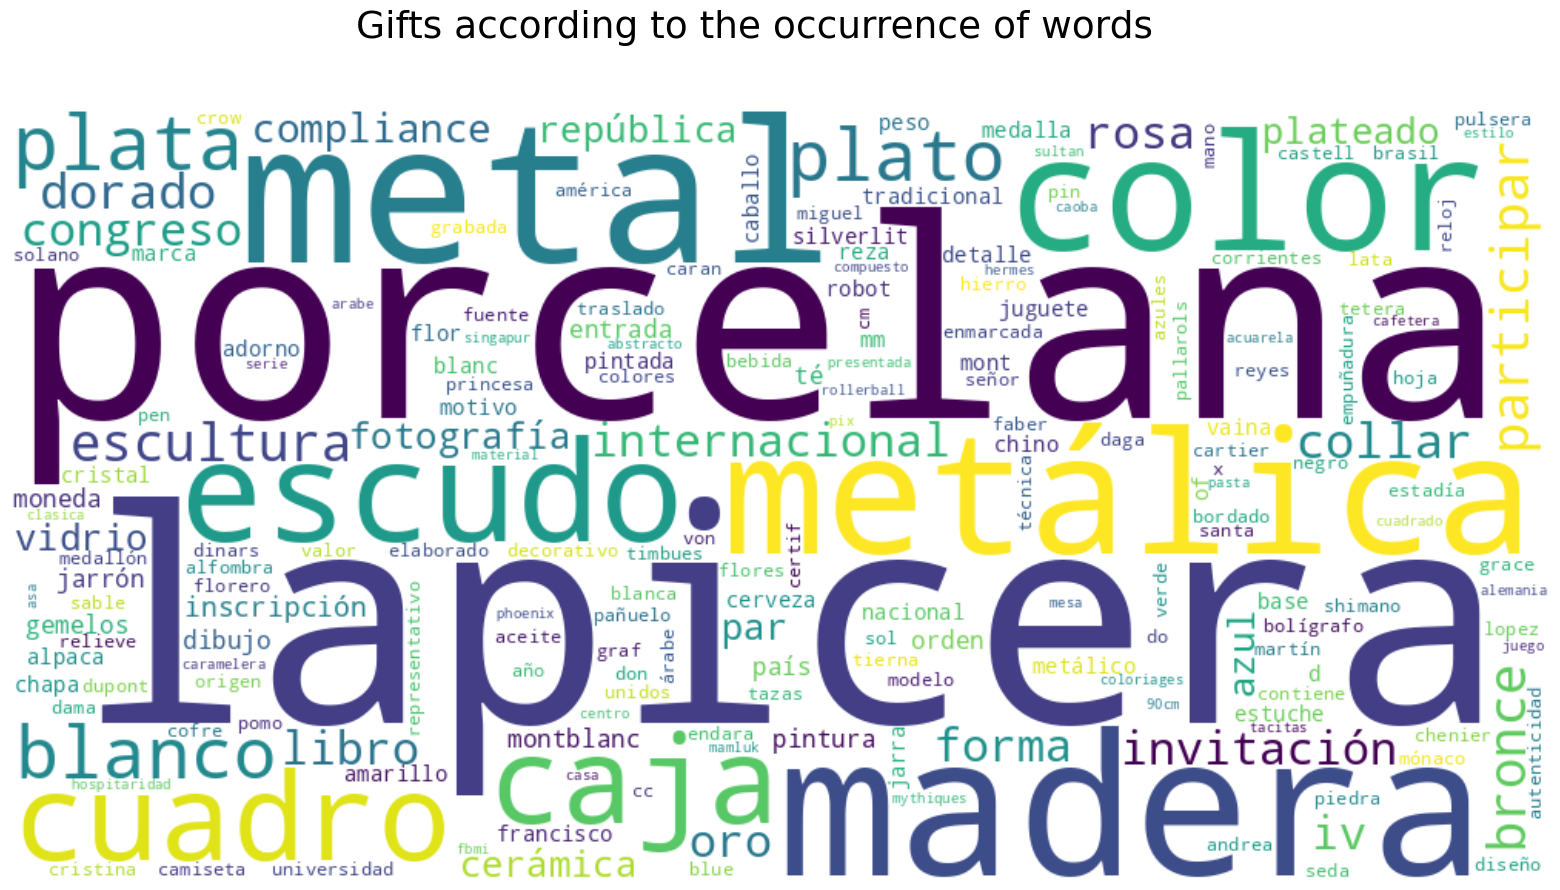

In [84]:
# word cloud visualization
allWords = ' '.join(expensive_gifts.obsequio_descripcion)
wordCloud = WordCloud(background_color="white", width=1000, height=500,random_state=21, stopwords=STOP_WORDS, collocations=False)
wordCloud.generate(allWords)

#show
fig = plt.figure(figsize=(20, 10))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
fig.suptitle("Gifts according to the occurrence of words", fontsize=27)
plt.show()

#store to file
#wordCloud.to_file(path.join(d, "christmas_for_politicians.png"))

## "Problems" and suggestions for improvement

- As 'funcionario_nombre' appears "Jefatura Jefatura", "Prueba Prueba", "X X". 
    - <ins>Suggestion</ins>: to facilitate the cleaning and processing of information, it would be good to select politicians from a unified database so that the information is consistent throughout the systems that require the use of such information. 

- The function and name of those who receive gifts is often mislabelled, for example: "Mauricio Macri is listed as _Mrs. First Lady_ and _Daughter of the President, Ms Antonia Macri_.
    - <ins>Suggestion</ins>: as proposed in the previous case, having a database from which funcionarixs are selected would allow more people to use it and detect possible typing errors, data inconsistencies, etc.
    
- Names of repeated politicians: the same names appear several times, as well as positions (for example: "President, President of the Nation, President of the Nation [note that it has more spaces between words]". 
    - Suggestion: It would be good to standardise the data, as well as to have a unique database of politicians and their functions so that not what each person considers is written, but rather an option to be selected from that database.


- It would be good to have a "status" field or something like that on every gift, where you can report whether it was transferred to the state's assets, whether it was confiscated for some reason, or whatever needs to be said about it. We saw that in the case of confiscated gifts, that fact was recorded in the descriptions ("soiling" that field).